# **The Vehicle Type Classification Project**



# Summary


- **Use Case:** Vehicle Type
- **Algorithm:** MobileNetV2
- **Number of training images:** 603
- **Number of classes:** 7
- **Batch Size:** 64
- **Optimizer:** Adam 
- **Learning Rate:** 0.0001
- **Loss Type:**CategoricalCrossentropy
- **Transfer Learning:** Yes | Imagenet



 ## Labels
 
 0: 'car-bus-alltypes',

 1: 'car-sedan-alltypes',
 
 2: 'car-suv-alltypes',
 
 3: 'motocycle-bicycle-kids',
 
 4: 'motocycle-bicycle-racing',
 
 5: 'motocycle-motorbike-chopper',
 
 6: 'motocycle-motorbike-sport'

## Import Library

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf
import h5py
import numpy as np
import sys

In [2]:
print(tf.__version__)

2.4.1


## 구글드라이브 마운트 하기

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/data-vision/day19')

In [ ]:
!unzip 38_실습파일.zip

### 다음 데이터셋을 다운로드하여, 압축을 풀고, 구글 드라이브에 올려놓는다.

https://drive.google.com/file/d/1oAW1QoG77-WLPkPa2tAM4Mnpt1cznnDl/view?usp=sharing


## 경로 셋팅

In [148]:
# 실무 tip
# 실무에서 파일을 쉽게 구분할 수 있게 변수를 지정
TYPE='type'
model_type='mobilenetv2'
user='block'
iteration='1-2'

first_time_training=True

PROJECT_PATH= '/content/drive/MyDrive/Colab Notebooks/data-vision/day19'

HDF5_DATASET_PATH=PROJECT_PATH+'/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5'

TARGET_CLASSIFICATION_MODEL=PROJECT_PATH+'/trained-models/'+model_type+'/'+'vehicle-classification-by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

# 매 에포크를 할 때마다 한번 끝날 때 val_accraracy가 전 보다 높을 때 저장 할 변수
CHECKPOINT_PATH = PROJECT_PATH+'/checkpoints/'+model_type+'/'+'by-'+TYPE+'-'+model_type+'-'+user+'-'+iteration+'.h5'

# 로그를 기록하기 위한 변수
LOGFILE_PATH=PROJECT_PATH+'/log/'+model_type+'/'+model_type+'-by-'+TYPE+'-training-log'+user+'-'+iteration+'.csv'


In [8]:
print('PROJECT_PATH: ',PROJECT_PATH)
print('HDF5_DATASET_PATH: ', HDF5_DATASET_PATH)
print('TARGET_CLASSIFICATION_MODEL: ',TARGET_CLASSIFICATION_MODEL)
print('CHECKPOINT_PATH: ',CHECKPOINT_PATH)
print('LOGFILE_PATH: ',LOGFILE_PATH)

PROJECT_PATH:  /content/drive/MyDrive/Colab Notebooks/data-vision/day19
HDF5_DATASET_PATH:  /content/drive/MyDrive/Colab Notebooks/data-vision/day19/vehicle_datasets/vehicle-type-dataset-SIZE224-train-dev-test-v2.hdf5
TARGET_CLASSIFICATION_MODEL:  /content/drive/MyDrive/Colab Notebooks/data-vision/day19/trained-models/mobilenetv2/vehicle-classification-by-type-mobilenetv2-block-1-2.h5
CHECKPOINT_PATH:  /content/drive/MyDrive/Colab Notebooks/data-vision/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
LOGFILE_PATH:  /content/drive/MyDrive/Colab Notebooks/data-vision/day19/log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-2.csv


In [149]:
# os.chdir과 같은 기능// 현재 디렉토리로 이동
sys.path.append(PROJECT_PATH)


# **Load the Dataset**

In [150]:
# hdf5로 되어 있는 파일  (확장자가 hdf5로 저장되어 있는 것)
hf = h5py.File(HDF5_DATASET_PATH, 'r')

In [151]:
hf['trainY']

<HDF5 dataset "trainY": shape (603, 7), type "<i8">

In [15]:
#np array로 보기
np.array( hf['trainY'][0,] )

array([0, 0, 0, 0, 0, 1, 0])

In [17]:
np.array( hf)

array(['devLabels', 'devX', 'devY', 'testLabels', 'testX', 'testY',
       'trainLabels', 'trainX', 'trainY'], dtype='<U11')

In [152]:
def load_dataset_from_hdf5_file(hdf_file_path):
  # 함수 만들기
  hf = h5py.File(hdf_file_path, 'r')
  
  X_train = np.array( hf['trainX'] )
  y_train = np.array( hf['trainY'] )

  # 따로 라벨링이 되어 있음
  train_label = np.array( hf['trainLabels'] )

  X_test = np.array( hf['testX'] )
  y_test = np.array( hf['testY'] )

  test_label = np.array( hf['testLabels'] )

  X_val = np.array( hf['devX'] )  
  y_val = np.array( hf['devY'] )  
  val_label = np.array( hf['devLabels'] )

  return X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label 

데이터 train셋, test셋, val셋 으로 저장

In [154]:
X_train, y_train, train_label, X_test, y_test, test_label, X_val, y_val, val_label = load_dataset_from_hdf5_file(HDF5_DATASET_PATH)

In [ ]:
y_val

In [ ]:
X_train

In [23]:
y_train

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
train_label

# 사진이미지 확인해 보기

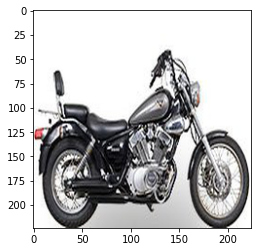

In [25]:
#사진보기 np array를 넣어준다
plt.imshow(X_train[0])

In [26]:
X_train[0].shape
# 224*224, 3(RGB)

(224, 224, 3)

In [29]:
X_train[0].max()

1.0

In [30]:
X_train[0].min()

0.0

In [ ]:
# 최대값이 1.0 최소값이 2.0 이므로
# 위의 결과로 이미 데이터가 정규화가 되어 있다. 이미 255로 나누어져 있음

In [31]:
y_train[0]

array([0, 0, 0, 0, 0, 1, 0])

In [34]:
y_train[0].argmax()

5

In [32]:
train_label[0]

b'motocycle-motorbike-chopper'

# 모델링하기 : 트랜스퍼 러닝 적용

# Data Augmentation

In [132]:
# 이미 normalization이 되어 있기 때문에 rescale은 필요 없음
trainGen = ImageDataGenerator(
    rotation_range = 20,
    horizontal_flip=True, 
    vertical_flip=True,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2, 
    fill_mode='nearest'
)

In [155]:
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
baseModel.summary()

In [156]:
headModel = baseModel.output

In [157]:
# add()를 사용하지 않지만, add와 같은 기능이라고 생각해도 됨
headModel = AveragePooling2D( (4,4))(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation='relu')(headModel)

In [158]:
# Dropout 처럼 오버피팅을 막아준다
headModel = BatchNormalization()(headModel)

In [159]:
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout( (0.5))(headModel)
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout( (0.5))(headModel)
headModel = BatchNormalization()(headModel)
headModel = Dense(7, activation='softmax')(headModel)

In [160]:
baseModel.trainable = False

In [161]:
model = Model(inputs = baseModel.input, outputs = headModel)

###  콜백 만들기 : 가장 좋은 모델을 자동 저장하도록 함. 로그도 저장하도록 함.

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
import pickle

In [66]:
CHECKPOINT_PATH

'/content/drive/MyDrive/Colab Notebooks/data-vision/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5'

In [162]:
# ModelCheckpoint()클래스로 val_accuray를 모니터해서 좋은 결과를 저장

cp = ModelCheckpoint(
    filepath= CHECKPOINT_PATH, monitor='val_accuracy',
    save_best_only=True, verbose =1,
    )

In [163]:
# CSVLooger() 클래스는 로그파일 저장할 수 있게 해줌
# append = True는 덮어쓸 수 있게 함
csv_logger = CSVLogger(filename=LOGFILE_PATH, append = True)

## 컴파일과 학습 : 에포크는 50

In [164]:
# 숫자 정수로 되어 있을 때는 categorical_croseentropy
# 예를 들어 7개로 분류 되는 것이면 sparse_categorical_crossentropy

model.compile(optimizer=Adam(lr=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [50]:
print(CHECKPOINT_PATH)

/content/drive/MyDrive/Colab Notebooks/data-vision/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5


In [ ]:
# CHECKPOINT_PATH:  /content/drive/MyDrive/Colab Notebooks/data-vision/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
# LOGFILE_PATH:  /content/drive/MyDrive/Colab Notebooks/data-vision/day19/log/mobilenetv2/mobilenetv2-by-type-training-logblock-1-2.csv



In [67]:
PROJECT_PATH

'/content/drive/MyDrive/Colab Notebooks/data-vision/day19'

In [84]:
if not os.path.exists(PROJECT_PATH + '/checkpoints/' + model_type + '/'):
  os.makedirs (PROJECT_PATH + '/checkpoints/' + model_type + '/')

if not os.path.exists(PROJECT_PATH + '/log/' + model_type + '/'):
  os.makedirs (PROJECT_PATH + '/log/' + model_type + '/')

In [165]:
# trainGen() .flow()
# flow_from_directory 로 하는 것이 아니라 
# 이번에는 위에서 만든 사용자 함수 trainGen를 활용해서 메모리에서 가져오기 때문에
# flow 메소드를 사용한다 

histroy = model.fit( trainGen.flow(X_train, y_train, batch_size=64),
                    steps_per_epoch = len(X_train) // 64,
                    validation_data = (X_val, y_val),
                    validation_steps = len(X_val) // 64,
                    epochs = 50, 
                    callbacks = [ cp, csv_logger]
                    )

# 한 에포크를 몇단계로 나눠서 학습 시킬 것인지 정함
# 예: 10000개의 데이터가 있다면, 5000개씩 학습을 하게 되면
# steps_per_epoch 는 2개 된다.
# 만개의 데이터를 1개씩 학습하면 steps_per_epoch 는 10000이 됨
# len(X_train) // 64  (나머지 소수점 빼고)는  

# batch_size 는 일괄로 한번에 메모리에 올려서 하는 것이므로 주의

Epoch 1/50
9/9 [==============================] - 10s 728ms/step - loss: 2.5642 - accuracy: 0.1595 - val_loss: 1.8741 - val_accuracy: 0.2800

Epoch 00001: val_accuracy improved from -inf to 0.28000, saving model to /content/drive/MyDrive/Colab Notebooks/data-vision/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
Epoch 2/50
9/9 [==============================] - 6s 612ms/step - loss: 2.4369 - accuracy: 0.1756 - val_loss: 1.8051 - val_accuracy: 0.3200

Epoch 00002: val_accuracy improved from 0.28000 to 0.32000, saving model to /content/drive/MyDrive/Colab Notebooks/data-vision/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
Epoch 3/50
9/9 [==============================] - 6s 633ms/step - loss: 2.3562 - accuracy: 0.2012 - val_loss: 1.7413 - val_accuracy: 0.4133

Epoch 00003: val_accuracy improved from 0.32000 to 0.41333, saving model to /content/drive/MyDrive/Colab Notebooks/data-vision/day19/checkpoints/mobilenetv2/by-type-mobilenetv2-block-1-2.h5
Epoch 4/5

# 트레이닝 및 밸리데이션의 정확도와 로스를 차트로 보기

In [166]:
import matplotlib.pyplot as plt

def learning_curve(history, epoch):
  #정확도 차트 (accuracy)
  # x축을 epoch_range로 셋팅
  epoch_range = np.arange(1, epoch +1)

  plt.figure(figsize=(16,8))
  plt.subplot(1, 2, 1)
  
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuraycy')
  plt.legend([ 'Train', 'Val' ] )
  # plt.show() // 차트를 따로 그리려면 위의 subplot()을 제거

  # 오차 차트 (loss) 
  plt.subplot(1, 2, 2) 

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend([ 'Train', 'Val' ] )
  plt.show()

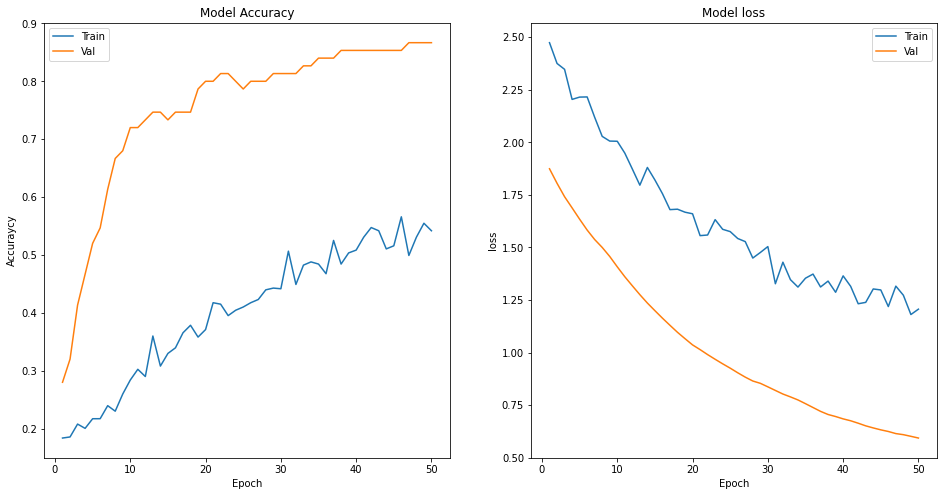

In [167]:
learning_curve(histroy, 50)

# 모델 평가

In [168]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 21ms/step - loss: 0.7069 - accuracy: 0.8553


[0.7068798542022705, 0.8552631735801697]

In [169]:
y_pred = model.predict(X_test)

In [170]:
y_pred = y_pred.argmax(axis=1)

In [97]:
y_pred

array([0, 0, 0, 1, 6, 1, 5, 4, 3, 4, 3, 1, 1, 4, 0, 0, 0, 3, 3, 2, 6, 5,
       6, 3, 4, 5, 3, 0, 3, 2, 6, 0, 0, 3, 0, 5, 6, 4, 3, 2, 2, 1, 2, 2,
       6, 0, 3, 1, 5, 3, 2, 3, 4, 0, 6, 5, 5, 5, 2, 1, 3, 5, 5, 1, 0, 4,
       1, 0, 1, 3, 1, 4, 4, 6, 2, 6])

In [171]:
# y_test로 7개 들어 있으므로 나머지는 0 argmax를 해서 
# 예측값 y_pred와 맞춰본다
y_test_argmax = y_test.argmax(axis= 1)

In [172]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [173]:
cm = confusion_matrix(y_test_argmax, y_pred)

In [174]:
accuracy_score(y_test_argmax, y_pred)

0.8552631578947368

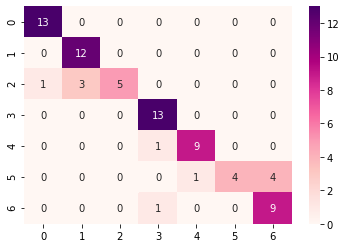

In [175]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='.0f', cmap= "RdPu")
plt.show()

# FINE 튜닝하기

Fine Tuning은 BAse모델은 건들지 않고 + head모델을 만들어서 학습을 한 후에 

다시 base모델의 일부분만 (base의 뒷부분)을 다시 학습을 하게 하는 것이
FINE TUNE 이다

FINE 튜닝은 이미 학습한 데이터에서 연속으로 이어서 한다

In [108]:
len(baseModel.layers)

154

In [110]:
# 전체 모델의 레이어 수 
len(model.layers)

# 헤드 모델 레이어는 확인이 안됨:

164

In [176]:
start_layer = 120


In [177]:
# fine튜닝으로 조금 수정해주기 위해서 다시 trainable 을 True로 바꿈
baseModel.trainable = True

In [178]:
for layer in baseModel.layers[ : start_layer ]:
  baseModel.trainable = False

# start_layer 를 120으로 했기 때문에 0~120까지는 False로 설정 
# 그 이후는 다시 True 해놓은 것에서 건들지 않게 됨 
# 120 이후로만 학습가능하게 만듬

In [ ]:
# 다시컴파일도 가능

In [179]:
model.compile (optimizer=Adam(lr=0.0001) ,
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

In [180]:
histroy_fine_tune = model.fit( trainGen.flow(X_train, y_train, batch_size=64),
                    steps_per_epoch = len(X_train) // 64,
                    validation_data = (X_val, y_val),
                    validation_steps = len(X_val) // 64,
                    epochs = 50, 
                    callbacks = [ cp, csv_logger]
                    )

Epoch 1/50
9/9 [==============================] - 10s 721ms/step - loss: 1.1629 - accuracy: 0.5758 - val_loss: 0.5744 - val_accuracy: 0.8667

Epoch 00001: val_accuracy did not improve from 0.86667
Epoch 2/50
9/9 [==============================] - 6s 653ms/step - loss: 1.1454 - accuracy: 0.5584 - val_loss: 0.5616 - val_accuracy: 0.8667

Epoch 00002: val_accuracy did not improve from 0.86667
Epoch 3/50
9/9 [==============================] - 5s 598ms/step - loss: 1.0937 - accuracy: 0.6031 - val_loss: 0.5518 - val_accuracy: 0.8667

Epoch 00003: val_accuracy did not improve from 0.86667
Epoch 4/50
9/9 [==============================] - 5s 601ms/step - loss: 1.0866 - accuracy: 0.6185 - val_loss: 0.5410 - val_accuracy: 0.8667

Epoch 00004: val_accuracy did not improve from 0.86667
Epoch 5/50
9/9 [==============================] - 5s 597ms/step - loss: 1.1428 - accuracy: 0.5816 - val_loss: 0.5300 - val_accuracy: 0.8667

Epoch 00005: val_accuracy did not improve from 0.86667
Epoch 6/50
9/9 [===

러닝커브 그려보기

In [118]:
import matplotlib.pyplot as plt

def learning_curve(history, epoch):
  #정확도 차트 (accuracy)
  # x축을 epoch_range로 셋팅
  epoch_range = np.arange(1, epoch +1)

  plt.figure(figsize=(16,8))
  plt.subplot(1, 2, 1)
  
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuraycy')
  plt.legend([ 'Train', 'Val' ] )
  # plt.show() // 차트를 따로 그리려면 위의 subplot()을 제거

  # 오차 차트 (loss) 
  plt.subplot(1, 2, 2) 

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend([ 'Train', 'Val' ] )
  plt.show()

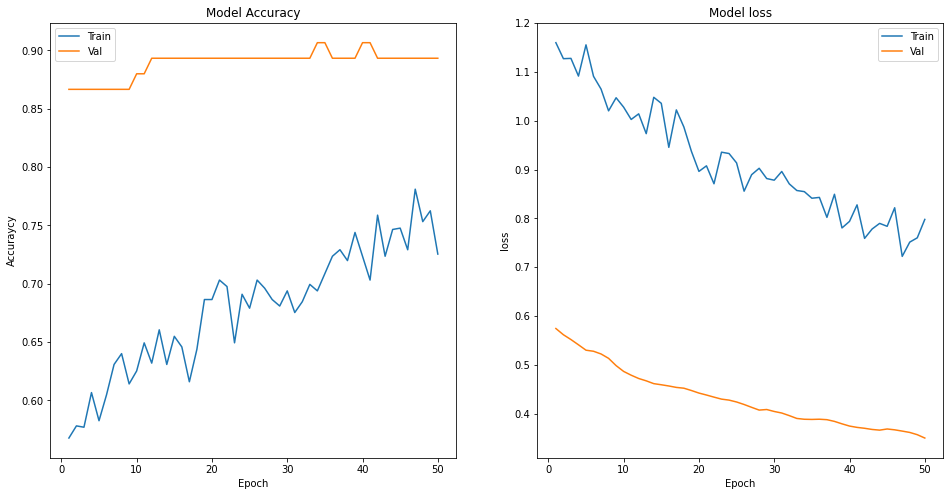

In [181]:
 learning_curve(histroy_fine_tune, 50)

In [182]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 1s 21ms/step - loss: 0.4020 - accuracy: 0.9342


[0.4019741117954254, 0.9342105388641357]

In [183]:
y_pred = model.predict(X_test)

In [186]:
y_pred = y_pred.argmax(axis=1)

In [189]:
y_test_argmax = y_test.argmax(axis=1)

In [190]:
cm2 = confusion_matrix(y_test_argmax, y_pred)

In [191]:
cm2

array([[12,  0,  0,  0,  0,  1,  0],
       [ 0, 12,  0,  0,  0,  0,  0],
       [ 1,  1,  7,  0,  0,  0,  0],
       [ 0,  0,  0, 13,  0,  0,  0],
       [ 0,  0,  0,  1,  9,  0,  0],
       [ 0,  0,  0,  0,  1,  8,  0],
       [ 0,  0,  0,  0,  0,  0, 10]])

In [192]:
accuracy_score(y_test_argmax, y_pred)

0.9342105263157895

히트맵

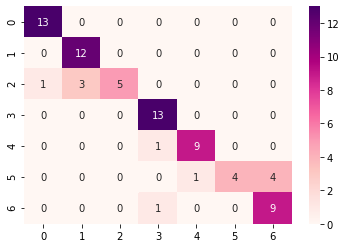

In [193]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='.0f', cmap= "RdPu")
plt.show()

학습시킨 가장 좋은 모델을 다른 서버나  
라즈베리파이나 폰 등에서 불러오는 방법  


In [147]:
# 특정경로에서 위에서 설정한 CHECKPOINT_PATH에서 모델을 불러온다
model = tf.keras.models.load_model(CHECKPOINT_PATH)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
model.evaluate(X_test, y_test)